<center><font size = "10"> Week 7 - Connections <center>
<center><font size = "8">Homework - Answers<center>

<font size = "3">Please, write your group number and the names and surnames of the group members here
<br>Group number:
<br>Group member1:
<br>Group member2:
<br>Group member3:

# <font color='red'> Ex1: </font> Connect all-to-all with random weights.

<font size='3'>In week 3 Home Works (Morphologies) each group received a set of ten morphology files to check their quality. Each set of cells have __FIVE__ good morphology files.

<font size='3'> For this exercise, connect your five cells all to all (unidirectionally) with random weights, as it is done in tutorial 01 of this week, and display the connectivity matrix with the weights.
    
<font color= 'red'>[1.5 pts]

### **Grading**: 
- <font color= 'red'>[0.5 pts]</font> for a clear setup of all the functions you need
- <font color= 'red'>[0.5 pts]</font> for a step by step process loading cells and connecting them
- <font color= 'red'>[0.5 pts]</font> for connection weights plot, with labels and legend

In [1]:
# Load useful packages
import os
from neuron import h, gui
import numpy as np
import math as m
import random as rd

import matplotlib.pyplot as plt
%matplotlib inline

--No graphics will be displayed.


_First, we define the `Cell` class._

In [2]:
class Cell:
    def __init__(self, filename, name, cell_type):
        self.name = name
        self.type = cell_type
        self.synapses = []
        self.build_morphology(filename)
        self.biophysics()
        
    def build_morphology(self, filename):
        h.load_file('import3d.hoc')
        h.load_file('stdlib.hoc')
        #morph_reader = h.Import3d_Neurolucida3()
        morph_reader = h.Import3d_SWC_read()
        morph_reader.input(filename)
        i3d = h.Import3d_GUI(morph_reader, 0)
        i3d.instantiate(self)
    
    def biophysics(self):
        # Insert passive properties in the neuron
        for sec in h.allsec():
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
            sec.insert("pas")
            for seg in sec:
                seg.pas.g = 0.00003
                seg.pas.e = -75
        
        # Insert active properties in the neuron
        for sec in self.soma:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        if hasattr(self, 'apic'):
            for sec in self.apic:
                sec.insert('hh')
                for seg in sec:
                    seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                    seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        for sec in self.dend:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
                
        for sec in self.axon:
            sec.insert('hh')
            for seg in sec:    
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

_We also define the functions used to create the random weight matrix, and to connect two neurons, as in the tutorials._

In [3]:
# returns NxN matrix of random weights in [0,1) with zero diagonal
def random_weights(n):
    rng = np.random.default_rng()
    weights = rng.random((n,n))
    np.fill_diagonal(weights,0.0)
    return weights

In [4]:
# connect two cells with an exponential synapse at given locations
# returns the netcon
def connect(source, target, weight = None, delay = 5, source_sec = None, source_neurite = 'axon', target_sec = None, target_neurite = 'dend'):
    rng = np.random.default_rng()
    
    if weight is None:
        weight = rng.uniform() # random weight
    
    target_neurite_ = getattr(target, target_neurite)
    if target_sec is None:
        target_sec = rng.integers(0,len(target_neurite_)) # random dendritic section
    
    source_neurite_ = getattr(source, source_neurite)
    if source_sec is None:
        source_sec = rng.integers(0,len(source_neurite_)) # random axonal section
    
    target_syn = h.ExpSyn(target_neurite_[target_sec](0.5))
    target.synapses.append(target_syn) # store synapse
    
    netcon = h.NetCon(source_neurite_[source_sec](0.5)._ref_v, target_syn, sec=source_neurite_[source_sec])
    netcon.weight[0] = weight
    netcon.delay = delay
    
    print('Connected cells %s -> %s with weight %g and delay %g, from %s[%d] to %s[%d]' % (source.name,target.name,weight,delay,source_neurite,source_sec,target_neurite,target_sec))
    return netcon

_Finally, we define the function to plot the connection matrix._

In [5]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """
    
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_xlabel("Target")
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.set_ylabel("Source")
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

_Now, we create the cells, display some stats and..._

In [6]:
Pyr1 = Cell('input/example_morphologies/Pyr_01.swc','Pyr1','Pyr')
Pyr2 = Cell('input/example_morphologies/Pyr_02.swc','Pyr2','Pyr')
Pyr3 = Cell('input/example_morphologies/Pyr_03.swc','Pyr3','Pyr')
Int1 = Cell('input/example_morphologies/Int_01.swc','Int1','Int')
Int2 = Cell('input/example_morphologies/Int_02.swc','Int2','Int')

cells_Pyr = [Pyr1, Pyr2, Pyr3]
cells_Int = [Int1,Int2]
cells = cells_Pyr + cells_Int

for c in cells_Pyr:
    print('%s: %d apical sections, %d basal sections, %d soma sections and %d axon sections' % (c.name,len(c.apic),len(c.dend), len(c.soma), len(c.axon)))
for c in cells_Int:
    print('%s: %d basal sections, %d soma sections and %d axon sections' % (c.name,len(c.dend), len(c.soma), len(c.axon)))

Pyr1: 73 apical sections, 72 basal sections, 1 soma sections and 281 axon sections
Pyr2: 67 apical sections, 47 basal sections, 1 soma sections and 123 axon sections
Pyr3: 27 apical sections, 40 basal sections, 1 soma sections and 111 axon sections
Int1: 69 basal sections, 1 soma sections and 323 axon sections
Int2: 37 basal sections, 1 soma sections and 169 axon sections


_... make all-to-all, random-weight, connections._

In [7]:
weight_matrix = random_weights(5)

netcons = [] # save the netcons in case we want to modify them later

for i, source_cell in enumerate(cells):
    for j, target_cell in enumerate(cells):
        if source_cell.name == target_cell.name:
            continue   # do not connect cells to themselves
        nc = connect(source_cell,target_cell,weight_matrix[i,j])
        netcons.append(nc)

Connected cells Pyr1 -> Pyr2 with weight 0.57645 and delay 5, from axon[86] to dend[29]
Connected cells Pyr1 -> Pyr3 with weight 0.72603 and delay 5, from axon[204] to dend[18]
Connected cells Pyr1 -> Int1 with weight 0.692385 and delay 5, from axon[271] to dend[17]
Connected cells Pyr1 -> Int2 with weight 0.816862 and delay 5, from axon[263] to dend[17]
Connected cells Pyr2 -> Pyr1 with weight 0.899925 and delay 5, from axon[113] to dend[57]
Connected cells Pyr2 -> Pyr3 with weight 0.776127 and delay 5, from axon[98] to dend[14]
Connected cells Pyr2 -> Int1 with weight 0.893004 and delay 5, from axon[64] to dend[39]
Connected cells Pyr2 -> Int2 with weight 0.318737 and delay 5, from axon[105] to dend[34]
Connected cells Pyr3 -> Pyr1 with weight 0.623348 and delay 5, from axon[62] to dend[12]
Connected cells Pyr3 -> Pyr2 with weight 0.0418267 and delay 5, from axon[87] to dend[41]
Connected cells Pyr3 -> Int1 with weight 0.18493 and delay 5, from axon[20] to dend[41]
Connected cells Py

_Display the resulting weight matrix:_

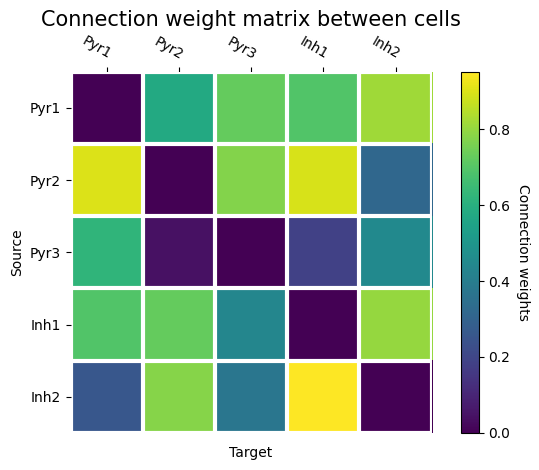

In [8]:
fig, ax = plt.subplots()

im, cbar = heatmap(weight_matrix, 
                   ['Pyr1', 'Pyr2', 'Pyr3', 'Inh1', 'Inh2'], 
                   ['Pyr1', 'Pyr2', 'Pyr3', 'Inh1', 'Inh2'], 
                   ax=ax, cmap="viridis", cbarlabel="Connection weights")

ax.set_title("Connection weight matrix between cells", fontsize = 15)
fig.tight_layout()

# <font color='red'> Ex2: </font> Connect your cells considering connection probability

<font size='3'> Connect your five cells as it is done in tutorial 02, considering the following connection probabilities between cell types:<br>
<br> PC - PC: 65 %
<br> PC - Inh: 23 %
<br> Inh - PC: 41 %
<br> Inh - Inh: 36 %

<font size='3'> Then show the results on a probability matrix.
    
<font color= 'red'>[1 pt]

### **Grading**: 
- <font color= 'red'>[0.5 pts]</font> for a step by step process loading cells and connecting them
- <font color= 'red'>[0.5 pts]</font> for probability matrix plot

_We re-create the cells, otherwise they will have retained the previous connections (although we don't really care, because we are not running any simulation)._

In [9]:
Pyr1 = Cell('input/example_morphologies/Pyr_01.swc','Pyr1','Pyr')
Pyr2 = Cell('input/example_morphologies/Pyr_02.swc','Pyr2','Pyr')
Pyr3 = Cell('input/example_morphologies/Pyr_03.swc','Pyr3','Pyr')
Int1 = Cell('input/example_morphologies/Int_01.swc','Int1','Int')
Int2 = Cell('input/example_morphologies/Int_02.swc','Int2','Int')

cells_Pyr = [Pyr1, Pyr2, Pyr3]
cells_Int = [Int1,Int2]
cells = cells_Pyr + cells_Int

_We specify the connection probabilites between cell types._

In [10]:
conn_prob_dict = {}
conn_prob_dict[("Pyr", "Pyr")] = 0.65 # Pyr to Pyr
conn_prob_dict[("Pyr", "Int")] = 0.23 # Pyr to Int
conn_prob_dict[("Int", "Pyr")] = 0.41 # Int to Pyr
conn_prob_dict[("Int", "Int")] = 0.36 # Int to Int

_We decide of connecting the neurons depending on the above probabilities, and retain the chosen weights in a matrix, then display this matrix._ 

In [11]:
weight_matrix = np.zeros((5,5))

netcons = [] # save the netcons in case we want to modify them later

rng = np.random.default_rng()

for i, source_cell in enumerate(cells):
    for j, target_cell in enumerate(cells):
        if source_cell.name == target_cell.name:
            continue   # do not connect cells to themselves
        if rng.random() < conn_prob_dict[(source_cell.type, target_cell.type)]:
            weight = rng.uniform()
            nc = connect(source_cell,target_cell,weight)
            netcons.append(nc)
            weight_matrix[i,j] = weight
            
prob_matrix = np.array([[conn_prob_dict[("Pyr", "Pyr")], 
                         conn_prob_dict[("Pyr", "Int")]],
                        [conn_prob_dict[("Int", "Pyr")], 
                         conn_prob_dict[("Int", "Int")]]])

Connected cells Pyr1 -> Pyr3 with weight 0.840077 and delay 5, from axon[69] to dend[9]
Connected cells Pyr2 -> Pyr1 with weight 0.0748439 and delay 5, from axon[111] to dend[1]
Connected cells Pyr2 -> Pyr3 with weight 0.888447 and delay 5, from axon[63] to dend[24]
Connected cells Pyr3 -> Pyr2 with weight 0.764218 and delay 5, from axon[101] to dend[29]
Connected cells Int1 -> Pyr1 with weight 0.791519 and delay 5, from axon[168] to dend[10]
Connected cells Int1 -> Pyr3 with weight 0.510776 and delay 5, from axon[3] to dend[36]
Connected cells Int1 -> Int2 with weight 0.770156 and delay 5, from axon[286] to dend[0]
Connected cells Int2 -> Int1 with weight 0.67708 and delay 5, from axon[39] to dend[36]


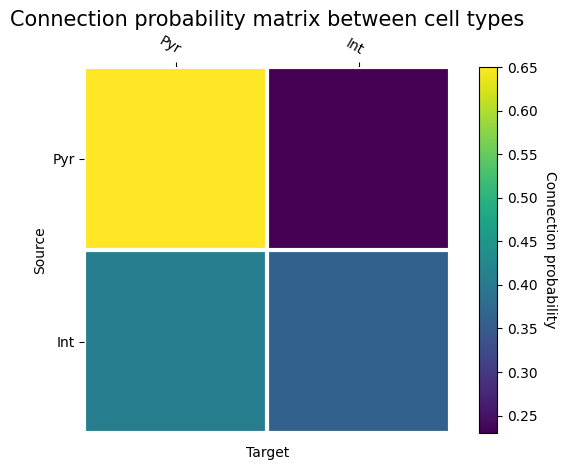

In [12]:
fig, ax = plt.subplots()
im, cbar = heatmap(prob_matrix, ['Pyr', 'Int'], ['Pyr', 'Int'], 
                   ax=ax, cmap="viridis", cbarlabel="Connection probability")

ax.set_title("Connection probability matrix between cell types", fontsize = 15)
fig.tight_layout()

# <font color='red'> Ex3: </font> Distribution of contacts: Convergence Matrix

<font size='3'> Consider the following mean contact points between cell types: 
<br> PC_axon - PC_basal: 4
<br> PC_axon - PC_apical: 1.5
<br> PC_axon - Inh_basal: 3
<br> Inh_axon - PC_soma: 3.5
<br> Inh_axon - PC_basal: 2
<br> Inh_axon - Inh_soma: 4
<br> Inh_axon - Inh_basal: 1.6

<font size='3'> Connect your cells by selecting the contact points from a normal distribution with a specific mean value per connection (values above). 
    
<font size='3'> Show the results on a __convergence__ matrix (how many contacts each of the cells receives from the others). 
    
<font color= 'red'>[2 pts]

### **Grading**: 
- <font color= 'red'>[1 pt]</font> for correct cell connections
- <font color= 'red'>[1 pt]</font> for the convergence matrix plot, with labels and legend

In [13]:
# specify expected number of contacts between cell types, considering target neurite
expected_contacts = np.zeros((2,2,3), dtype=int)

expected_contacts[0,0,0] = 0 # Pyr to Pyr (soma)
expected_contacts[0,0,1] = 4 # Pyr to Pyr (dend)
expected_contacts[0,0,2] = 1.5 # Pyr to Pyr (apic)

expected_contacts[1,0,0] = 3.5 # Int to Pyr (soma)
expected_contacts[1,0,1] = 2 # Int to Pyr (dend)
expected_contacts[1,0,2] = 0 # Int to Pyr (apic)

expected_contacts[0,1,0] = 0 # Pyr to Int (soma)
expected_contacts[0,1,1] = 3 # Pyr to Int (dend)

expected_contacts[1,1,0] = 4 # Int to Int (soma)
expected_contacts[1,1,1] = 1.6 # Int to Int (dend)

In [14]:
# generate number of contacts per cell type, by selecting them from a normal distribution 
# in which the mean is the expected_contacts value

netcons = [] # store all netcons

rng = np.random.default_rng()

for i, source_cell in enumerate(cells):
    for j, target_cell in enumerate(cells):
        if source_cell.name == target_cell.name:
            continue   # For now do not connect cells to themselves
        
        # Define the expected_contacts index depending on cell type
        if source_cell.type == 'Pyr':
            source_type = 0
        else :
            source_type = 1
        if target_cell.type == 'Pyr':
            target_type = 0
        else :
            target_type = 1
        
        # Add connection depending on expected contacts
        for n, neurite in enumerate(['soma', 'dend', 'apic']):
            contacts = expected_contacts[source_type, target_type, n]
            if contacts > 0:
                contacts = m.floor(rng.normal(contacts))
            if contacts < 0:
                contacts = 0
            for i in range(0, contacts):
                nc = connect(source_cell, target_cell, target_neurite=neurite)
                netcons.append(nc)

Connected cells Pyr1 -> Pyr2 with weight 0.0987951 and delay 5, from axon[87] to dend[26]
Connected cells Pyr1 -> Pyr2 with weight 0.0748258 and delay 5, from axon[115] to dend[46]
Connected cells Pyr1 -> Pyr2 with weight 0.0606735 and delay 5, from axon[16] to dend[44]
Connected cells Pyr1 -> Pyr2 with weight 0.588057 and delay 5, from axon[268] to dend[42]
Connected cells Pyr1 -> Pyr3 with weight 0.0201928 and delay 5, from axon[266] to dend[17]
Connected cells Pyr1 -> Pyr3 with weight 0.927037 and delay 5, from axon[185] to dend[14]
Connected cells Pyr1 -> Pyr3 with weight 0.372496 and delay 5, from axon[90] to dend[24]
Connected cells Pyr1 -> Int1 with weight 0.708473 and delay 5, from axon[7] to dend[44]
Connected cells Pyr1 -> Int1 with weight 0.368685 and delay 5, from axon[164] to dend[67]
Connected cells Pyr1 -> Int1 with weight 0.452072 and delay 5, from axon[63] to dend[33]
Connected cells Pyr1 -> Int2 with weight 0.965266 and delay 5, from axon[115] to dend[18]
Connected ce

/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_62628/3594904780.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['','Pyr1','Pyr2', 'Pyr3', 'Int1', 'Int2'])
/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_62628/3594904780.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['','Pyr1', 'Pyr2', 'Pyr3', 'Int1', 'Int2'])


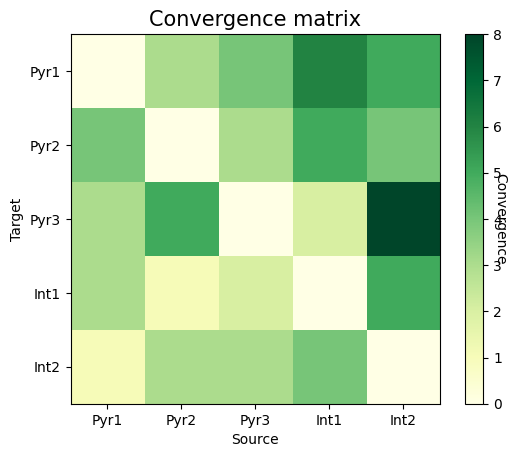

In [15]:
# Convergence matrix
contacts_matrix = np.zeros((5,5))
cellnames = [x.name for x in cells]

# iterate over netcons and count
for nc in netcons:
    pre = nc.precell().name
    pos = nc.postcell().name
    ipre = cellnames.index(pre)
    ipos = cellnames.index(pos)
    contacts_matrix[ipos,ipre] += 1

fig, ax = plt.subplots()
ax.set_title("Convergence matrix", fontsize = 15)
ax.set_xticklabels(['','Pyr1','Pyr2', 'Pyr3', 'Int1', 'Int2'])
ax.set_yticklabels(['','Pyr1', 'Pyr2', 'Pyr3', 'Int1', 'Int2'])
plt.xlabel('Source')
plt.ylabel('Target')
plt.imshow(contacts_matrix, cmap="YlGn")
cbar = plt.colorbar()
cbar.set_label("Convergence", rotation=270)

# <font color='red'> Ex4: </font>  Real Connectivity Rules

<font size='3'> Imagine that you have to build a network with your five cells (3 pyramidals and 2 GABAergic interneurons) from rat somatosensory cortex. <br> In this situation you'd have to extract real connectivity rules for articles and decide how you can use them as parameters.
    
<font size='3'> For this exercise read the short Gupta et al. (2000) paper provided and digest it, writing below all the points that seem important when thinking about connectivity rules for various Int --> Int and Int --> Pyr.
    
<font size='3'> Use a mix of bullet points and complete sentences to summarise and comment every piece of information. Take some time with expressing your ideas precisely and concisely. Consider it exam practice.    
    
<font color= 'red'> [1.5 pts]
    
<font size='3'> _Hint_: If you need help, you can follow these points:
    1) give an overview of the paper and the parameters they report
    2) what is the overall connection probability for the cells they are examining?
    3) what are the three different classes of GABAergic synapses they observed?
    4) what are the three principles of synapse formation they mention?

### **Grading levels**: 
- <font color= 'red'>[1.5 pts]</font> if summary contains >80% of the points in the reference answer, well organised
- <font color= 'red'>[1.2 pts]</font> if summary contains ~70% of the points in the reference answer
- <font color= 'red'>[0.8 pts]</font> if summary contains ~50% of the points in the reference answer
- <font color= 'red'>[0.4 pts]</font> if summary contains <30% of the points in the reference answer

### <font color= 'red'>Organizing principles for a diversity of GABAergic interneurons and synapses in the neocortex (Gupta 2000)
The synaptic connections between presynaptic interneturons and postsynaptic pyramidal cells have been studied by means of electrophysiological recordings. 
<br> The parameters to model synaptic connection have been retrieved from the average synaptic responses. In particular we have:
- F = time constant to recover from facilitation
- D = time constant to recover from depression
- A = absolute strength of the connection (quantal size x # release sites)
- Coefficient of variation CV
- Failure of transmission

***
<font  size='3' color= 'red'> _General connection probability:_

On the first "around 3000 potential GABAergic connections" and "there were more than 240 GABAergic connections". To find the probability of a GABAergic connection we simply divide the number of connections by the number of potential connections : <br>
<b>P(GABA connection)</b> = 240/3000 = <b>0.08 (8%)</b>. <br>

***
<font  size='3' color= 'red'> _They observed three different classes of GABAergic synapses depending on the recovery test response RTR compared to the first response in the AP train (distinguishable by the F:D ratio). Here are the classes and some important characteristics:_

**F1 GABAergic synapses: facilitated RTR (D~10xF)**
 - Total occurrence: 13.4% ; IN to PC: 7.6%; IN to IN: 29.2%
 - Failures(%) 26.8 +/- 26.3
 - Maximal conductance (nS): 3.24+/- 2.6 ; Conductance per synapse(nS): 0.35 +/- 0.28
 - Synapse numbers: 9.3+/-3.1
 
**F2 GABAergic synapses: depressed RTR (D~40xF)**
 - Total occurrence: 71.5% ; IN to PC: 76.3%; IN to IN: 58.3%
 - Failures(%) 5.14 +/- 8.7
 - Maximal conductance (nS): 7.76 +/- 6.6 ; Conductance per synapse(nS): 0.49 +/- 0.41
 - Synapse numbers: 16+/-5.5
 
**F3 GABAergic synapses: unchanged/recovered RTR (D~F)**
 - Total occurrence: 15.1% ; IN to PC: 16%; IN to IN: 12.5%
 - Failures(%) 8.89 +/- 11.85
 - Maximal conductance (nS): 3.44 +/- 0.84 ; Conductance per synapse(nS): 0.2 +/- 0.05
 - Synapse numbers: 16.7+/-11.9

***
<font  size='3' color= 'red'> _They also reflect on the different INTs based on their morphology, wiring and electrophysiological responses. They mention three principles:_

**Synapse mapping principle** <br>
Specific classes of INTs form specific types of synapses onto Pyr and INTs.

**Presynaptic-postsynaptic interaction principle** <br>
Different classes of INTs can form different types of synapses with the same class of target neurons. The postsynaptic cell does not define the type of synapses that are formed. By looking at the divergence map, they saw that the same INT axon can form different types of synapses with different types of target neruons. Therefore, the type of synapses depend on specific interactions between pre- and postsynaptic cells.

**Synaptic homogeneity principle** <br>
INTs form synapses with homogeneous D, F (i.e. identical temporal dynamics) with different targets of the same class. Only A differs. The same principle is true also for different classes of target neurons. Therefore, INTs form "GABA groups" where the same type of synapse is present for a given group of target neurons. Note also that an INT can form different GABA groups; all pyramidal neurons in layers II and IV are in the same GABA group.

***